In [46]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn as nn
from torchvision.transforms import v2
import multiprocessing

In [47]:
# run variables

seed = 42
file_name = 'student_self_taught2'
epochs = 19

class BaseNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNN, self).__init__()

        ### student2
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [48]:
# device settings

num_workers = multiprocessing.cpu_count() // 2

print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

AMD Radeon RX 7800 XT
Using cuda device


In [49]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = torchvision.datasets.CIFAR10("./../data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10("./../data", train=False, transform=transform, download=True)

train_dataset, validation_dataset =  random_split(train_dataset, [0.8, 0.2])

print('train set size:', len(train_dataset))
print('validation set size:', len(validation_dataset))
print('test set size:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

train set size: 40000
validation set size: 10000
test set size: 10000


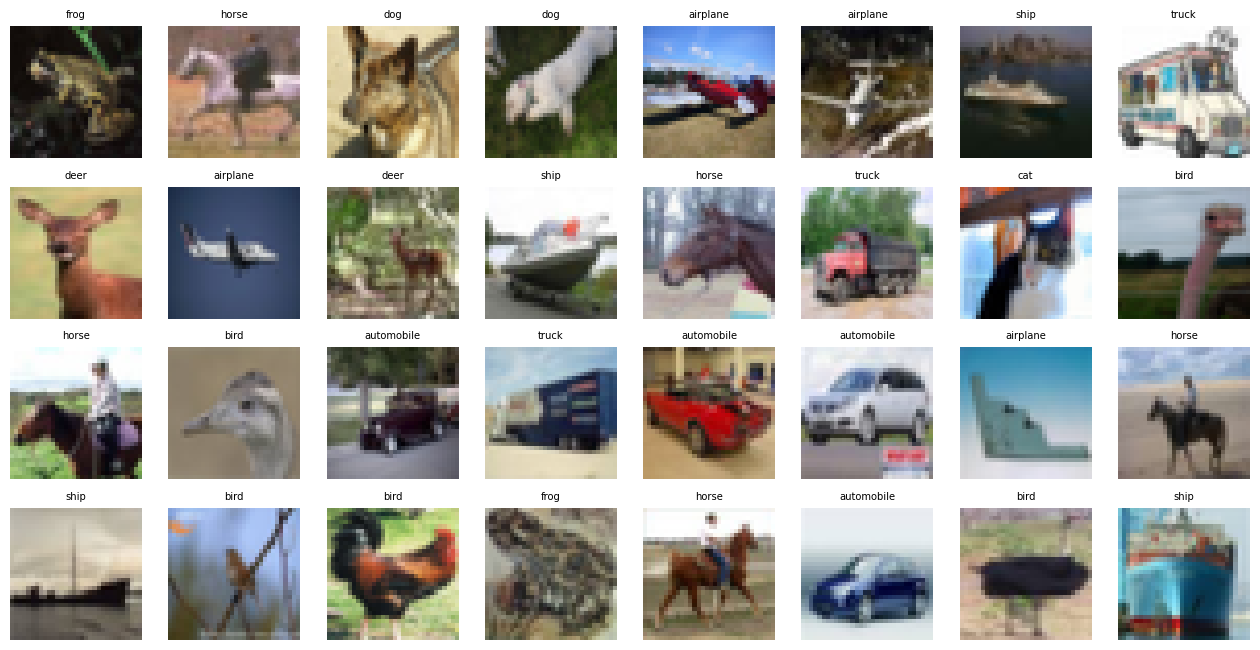

In [50]:
# show example data

exampleTransform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
exampleTrainDataset = torchvision.datasets.CIFAR10("./../data", train=True, transform=exampleTransform, download=True)
exampleTrainLoader = DataLoader(exampleTrainDataset, batch_size=32, shuffle=True, num_workers=num_workers)

for images_batch, labels_batch in exampleTrainLoader:
    plt.figure(figsize=(16,8))
    plt.rc('font', size=6)

    for index in range(32):
        plt.subplot(4,8,index+1)
        plt.imshow(images_batch[index].squeeze().permute(1,2,0))
        plt.title(class_names[labels_batch[index]])
        plt.axis('off')

    
    plt.ioff()
    plt.show()
    break

In [51]:
def train(model, epochs, learning_rate):
    trainingEpoch_loss = []
    validationEpoch_loss = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        trainingEpoch_loss.append(running_loss / len(train_loader))

        # validation
        model.eval()
        validation_loss = 0.0
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()

        validationEpoch_loss.append(validation_loss / len(validation_loader))
        
    return trainingEpoch_loss, validationEpoch_loss

In [52]:
def test(model):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [53]:
torch.manual_seed(seed)
model_base = BaseNN(num_classes=10).to(device)


In [54]:
trainingEpoch_loss, validationEpoch_loss = train(model_base, epochs=epochs, learning_rate=0.001)

Epoch 1/19, Loss: 1.671521035246194
Epoch 2/19, Loss: 1.3451258317350199
Epoch 3/19, Loss: 1.2184058347829996
Epoch 4/19, Loss: 1.1328456799824016
Epoch 5/19, Loss: 1.0707450141541113
Epoch 6/19, Loss: 1.01244788543104
Epoch 7/19, Loss: 0.9716399605281818
Epoch 8/19, Loss: 0.933169280949492
Epoch 9/19, Loss: 0.9053397068200401
Epoch 10/19, Loss: 0.8731178321396581
Epoch 11/19, Loss: 0.8523934441633498
Epoch 12/19, Loss: 0.8284099795186101
Epoch 13/19, Loss: 0.8104823705868218
Epoch 14/19, Loss: 0.7994332690589344
Epoch 15/19, Loss: 0.7753698997223339
Epoch 16/19, Loss: 0.7632190061453432
Epoch 17/19, Loss: 0.7526283738331292
Epoch 18/19, Loss: 0.7390231716747101
Epoch 19/19, Loss: 0.7292484775328407


37s

In [55]:
test(model_base)

Test Accuracy: 73.90%


73.9

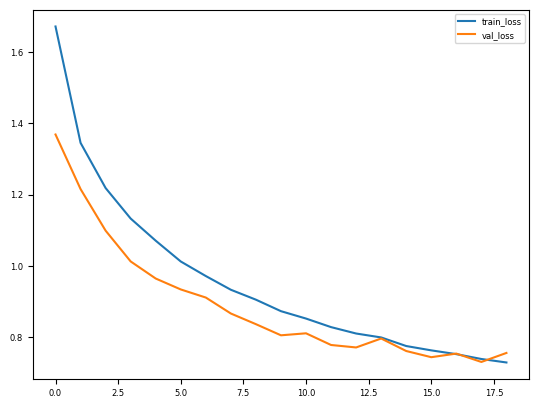

In [56]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
# plt.ylim(top=2)
plt.show()

In [57]:
torch.save(model_base.state_dict(), "../models/" + file_name + ".pt")